In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os, tempfile

# find .py modules in subfolders
import my_paths

# auto reload changed modules
%load_ext autoreload
%autoreload 2

# fix cuDNN init error
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# profiler
# %load_ext line_profiler

### Training settings

In [2]:
%%writefile model/training_settings.py
import keying_stats as ks

training_settings = {
    # signal properties
    'snr': {'low': -16, 'high': 50},
    'wpm': {'low':8, 'high':50},
    'doppler_spread': {'low':0.1, 'high':3},    
    'keying_style': [[ks.KeyingStyle.HandKey, ks.KeyingStyle.Paddle, ks.KeyingStyle.Computer], [0.25,0.5,0.25]], 
    # 'keying_style': ks.KeyingStyle.Paddle,
    'pitch_error': {'low':-30, 'high':30},
    'noise_floor': {'low':-20, 'high':20},
    
    # spectrogram properties
    'frame_step': 64, # 64 => 93.75 ms
    'window_function_length': 300,

    # tech consts
    'spectrogram_width': 512,
    'spectrogram_height': 22,
    'overlap_margin': 3,
    'continuous': True,
    'fft_length': 512, # 512 => 11.7 Hz, 

    # training properties
    'batch_size': 4,
    'batch_count': int((30 * 60 * 6000) / (64 * (256 * 2))),
    'randomize_every_batches': 5
}    

Overwriting model/training_settings.py


### Generate training data

In [3]:
import tensorflow as tf
import text_generator as tg
import morse_dataset as md
import training_settings as ts

training_settings = ts.training_settings
print(f"Batch count: {training_settings['batch_count']}")

# generate data
train_ds = md.create_morse_dataset(training_settings)

validation_settings = training_settings.copy()
validation_settings['batch_count'] = 1000000000
validation_ds = md.create_morse_dataset(validation_settings)

Batch count: 329


### View training data

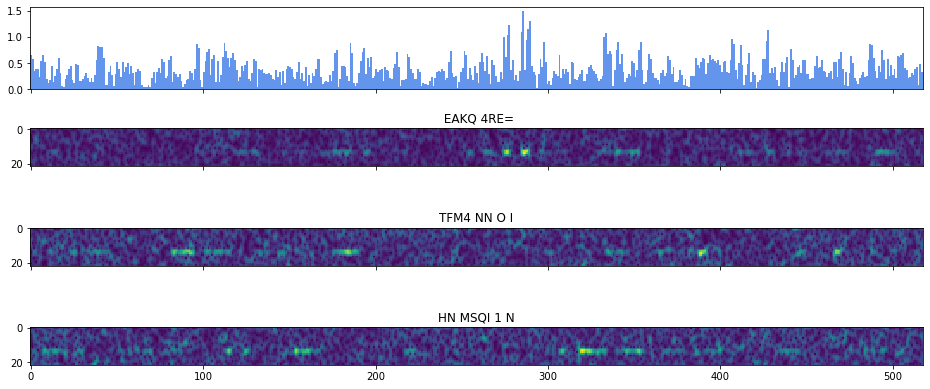

In [4]:
# plot
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(16, 7))
b=1
for batch in validation_ds.take(3):
    spectra = batch[0][0][:,:,0].numpy().T
    if b == 1:
        bin_magnitude = np.abs(spectra[validation_settings['spectrogram_height']//2])
        f = np.linspace(0, len(bin_magnitude), len(bin_magnitude))
        axes[0].bar(f, bin_magnitude, color='cornflowerblue', width=1.1)

    axes[b].imshow(spectra, interpolation='none')
    axes[b].set_title(tg.num_to_morse_text( batch[1][0]))
    b += 1
plt.show()

### Model

In [5]:
%%writefile model/model_builder.py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import text_generator as tg

def build_model(batch_size, spectrogram_width, overlap_margin, spectrogram_height, stateful=True):
    # Inputs to the model
    batch_shape = (batch_size, spectrogram_width + 2 * overlap_margin, spectrogram_height, 1)
    spectrogram = layers.Input(batch_shape=batch_shape, dtype=tf.float32, name='input_layer')    
    target = layers.Input(shape=(None,), dtype=tf.int64) 
    
    x = spectrogram
    
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="valid", name='conv2D_1')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="valid", name='conv2D_2')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    new_shape = ((spectrogram_width // 4), ((spectrogram_height - 2 * overlap_margin) // 4) * 64)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation="relu", name='dense_1')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.LSTM(256, return_sequences=True, dropout=0.1, stateful=stateful, name='lstm')(x)

    logits = layers.Dense(tg.MORSE_ALPHABET_SIZE, activation="softmax", name='output_layer')(x)

    model = keras.models.Model(inputs=spectrogram, outputs=logits, name='cw_model')
    return model

Overwriting model/model_builder.py


### Greedy decoder

In [15]:
%%writefile model/greedy_decoder.py
import numpy as np
import text_generator as tg

class GreedyDecoder:
    def __init__(self):        
        self.last_num = tg.MORSE_ALPHABET_SIZE
        self.skip_count = 2
        self.nums = np.array([], dtype=np.int64)
        
    def decode_probs(self, probs):
        self.skip_count -= 1
        if self.skip_count >= 0: return

        num = np.argmax(probs)
        if num != self.last_num and num != tg.MORSE_ALPHABET_SIZE:
            self.nums = np.append(self.nums, num)
        self.last_num = num
        
    def decode_trellis(self, trellis):
        for probs in trellis:
            self.decode_probs(probs)
            
    def get_text(self):
        return tg.num_to_morse_text(self.nums)   

Overwriting model/greedy_decoder.py


### Accuracy

In [7]:
%%writefile model/accuracy.py
import greedy_decoder as gd
import text_generator as tg

def levenshtein_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]


def compute_accuracy_cont(data_source, test_model, settings, print_messages=False, chars_to_use=1000):
    trellis_length = settings['spectrogram_width'] // 4
    trellis_height = tg.MORSE_ALPHABET_SIZE
    trellis_count = settings['randomize_every_batches']
    batch_size = settings['batch_size']

    total_count = 0
    char_count = 0
    total_err_count = 0
    char_err_count = 0
    
    # process as many batches as needed to get 1000 chars
    while total_count < chars_to_use:
        test_model.reset_states()
        decoders = [gd.GreedyDecoder() for _ in range(batch_size)]
        y_pred = [''] * batch_size
        y_true = [''] * batch_size
        
        # get (randomize_every_batches) batches, predict, merge y_pred and y_true
        for batch in data_source.take(trellis_count):
            prediction = test_model.predict(batch[0])
            for b in range(batch_size):
                decoders[b].decode_trellis(prediction[b])
                y_true[b] += tg.num_to_morse_text(batch[1][b])
        y_pred = [decoder.get_text() for decoder in decoders]
        
        # count chars, spaces and errors
        for b in range(batch_size):
            y_pred[b] = y_pred[b].strip()
            y_true[b] = y_true[b].strip()
            if print_messages and y_pred[b] != y_true[b]:                          
                print(f'true: "{y_true[b]}"\npred: "{y_pred[b]}"')
            total_count += len(y_true[b])
            total_err_count += levenshtein_distance(y_pred[b], y_true[b])
            
            y_pred[b] = y_pred[b].replace(' ', '')
            y_true[b] = y_true[b].replace(' ', '')
            char_count += len(y_true[b])
            char_err_count += levenshtein_distance(y_pred[b], y_true[b])            
    
    # compute error rate
    char_err_rate = char_err_count / char_count if char_count > 0 else -1
    space_count = total_count - char_count
    space_err_rate = (total_err_count - char_err_count) / space_count if space_count > 0 else -1
    return char_err_rate, space_err_rate        

Overwriting model/accuracy.py


### Loss function

In [8]:
%%writefile model/loss_func.py
import tensorflow as tf
from tensorflow import keras
import text_generator as tg

def ctc_loss_function(y_true, y_pred):
    return keras.backend.ctc_batch_cost(
        y_true, 
        y_pred, 
        tf.fill([tf.shape(y_pred)[0], 1], tf.shape(y_pred)[1]),
        tf.math.count_nonzero(y_true - (tg.MORSE_ALPHABET_SIZE-1), axis=-1, keepdims=True, dtype=tf.int32)
    )    

Overwriting model/loss_func.py


### Callbacks

In [9]:
%%writefile model/callbacks.py
import os, datetime, tempfile, shutil
import tensorflow as tf
import accuracy

class AccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, data_source, settings, logdir):
        self.writer = tf.summary.create_file_writer(logdir)
        self.data_source = data_source
        self.settings = settings

    def on_epoch_end(self, epoch, logs=None):
        char_error_rate, space_error_rate = accuracy.compute_accuracy_cont(self.data_source, self.model, self.settings)
        print('Char error rate: {:.2f}%   Space error rate: {:.2f}%' \
              .format(100 * char_error_rate, 100 * space_error_rate))
        
        with self.writer.as_default():
            tf.summary.scalar('char_error_rate', char_error_rate, step=epoch)
            
def get_logdir():
    time_string = datetime.datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
    return os.path.join(tempfile.gettempdir(), 'tensorboard_logs', time_string)

def get_callbacks(dataset, settings, logdir):
    return [AccuracyCallback(dataset, settings, logdir), tf.keras.callbacks.TensorBoard(logdir)]

Overwriting model/callbacks.py


### Build model

In [10]:
import loss_func
import model_builder

model = model_builder.build_model(
    training_settings['batch_size'], 
    training_settings['spectrogram_width'], 
    training_settings['overlap_margin'], 
    training_settings['spectrogram_height']
)

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss_func.ctc_loss_function)
model.summary()
# model.to_json()

Model: "cw_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(4, 518, 22, 1)]         0         
_________________________________________________________________
conv2D_1 (Conv2D)            (4, 516, 20, 32)          320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (4, 258, 10, 32)          0         
_________________________________________________________________
conv2D_2 (Conv2D)            (4, 256, 8, 64)           18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (4, 128, 4, 64)           0         
_________________________________________________________________
reshape (Reshape)            (4, 128, 256)             0         
_________________________________________________________________
dense_1 (Dense)              (4, 128, 64)              164

### Train model

In [11]:
%%time
import callbacks

logdir = callbacks.get_logdir()
print(f'logdir = {logdir}\n')
callback_array = callbacks.get_callbacks(validation_ds, training_settings, logdir)

history = model.fit(train_ds, epochs=50, validation_data=None, callbacks=callback_array, shuffle=False)

logdir = C:\Users\Alex\AppData\Local\Temp\tensorboard_logs\2024-10-26_12_41_51

Epoch 1/50
      6/Unknown - 13s 330ms/step - loss: 309.0525WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0790s vs `on_train_batch_end` time: 0.2097s). Check your callbacks.
329/329 [==============================] - 47s 107ms/step - loss: 99.8470
Char error rate: 100.00%   Space error rate: 100.00%
Epoch 2/50
329/329 [==============================] - 32s 98ms/step - loss: 74.7016
Char error rate: 100.00%   Space error rate: 100.00%
Epoch 3/50
329/329 [==============================] - 29s 89ms/step - loss: 77.3112
Char error rate: 100.00%   Space error rate: 100.00%
Epoch 4/50
329/329 [==============================] - 29s 88ms/step - loss: 71.6161
Char error rate: 100.00%   Space error rate: 100.00%
Epoch 5/50
329/329 [==============================] - 27s 81ms/step - loss: 73.7643
Char error rate: 100.00%   Space error rate: 100.00%
Epoch 6/50


### Save weights

In [21]:
import os
import tempfile
import shutil
                         
# save model
path = os.path.join(tempfile.gettempdir(), 'saved_model')
os.makedirs(path, exist_ok=True)
model.save(path, save_format='tf', save_traces=False, include_optimizer=False)

# save weights
path = os.path.abspath(os.path.join('model'))
path = os.path.join(path, 'weights.h5')
model.save_weights(path)

### Recreate model, load weights

In [13]:
import training_settings as ts
import model_builder
import os
import tempfile

# create model 2
test_settings = ts.training_settings.copy()

model2 = model_builder.build_model(
    1, # override test_settings['batch_size'], 
    4, # override test_settings['spectrogram_width'], 
    test_settings['overlap_margin'], 
    test_settings['spectrogram_height'],
    True
)
model2.summary()

# load weights
path = os.path.join(tempfile.gettempdir(), 'saved_weights', 'weights.h5')
model2.load_weights(path)

# save model 2
path = os.path.join(tempfile.gettempdir(), 'saved_model_2')
os.makedirs(path, exist_ok=True)
model2.save(path, save_format='tf', include_optimizer=False) #save_traces=False)#, 

print(path)
!saved_model_cli show --dir $path  --tag_set serve --signature_def serving_default

Model: "cw_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(1, 10, 22, 1)]          0         
_________________________________________________________________
conv2D_1 (Conv2D)            (1, 8, 20, 32)            320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (1, 4, 10, 32)            0         
_________________________________________________________________
conv2D_2 (Conv2D)            (1, 2, 8, 64)             18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (1, 1, 4, 64)             0         
_________________________________________________________________
reshape_1 (Reshape)          (1, 1, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (1, 1, 64)                164

INFO:tensorflow:Assets written to: C:\Users\Alex\AppData\Local\Temp\saved_model_2\assets


INFO:tensorflow:Assets written to: C:\Users\Alex\AppData\Local\Temp\saved_model_2\assets


C:\Users\Alex\AppData\Local\Temp\saved_model_2
The given SavedModel SignatureDef contains the following input(s):
  inputs['input_layer'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 10, 22, 1)
      name: serving_default_input_layer:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_layer'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 1, 43)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2024-10-26 13:08:09.528309: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
